### Load the data

In [1]:
import pandas as pd
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ijson
from tqdm import tqdm
from scipy.stats import percentileofscore
import ipywidgets as widgets
from IPython.display import display, clear_output
from tabulate import tabulate
import pickle
import heapq
from prettytable import PrettyTable

Here we load the data as running every time the code for creating the graphs will require a lot of time.

In [2]:
file_path = "citation_graph.json"

with open(file_path, 'r') as json_file:
    graph_data = json.load(json_file)

#create graph from the data -- citation graph 
G = nx.node_link_graph(graph_data)

In [3]:
file_path = "collaboration_graph.json"

# Read the graph data from the JSON file
with open(file_path, 'r') as json_file:
    graph_data = json.load(json_file)

#create graph from the data -- collaboration graph 
N = nx.node_link_graph(graph_data)

# 2 - Controlling System

## 2.1 - Backend 

### Functionality 1 - Graph's features

Here we create the functionality 1. In each step, we compute one of the metrics requested and then print them as result.

In [4]:
def graph_features(graph, graph_name):
    #n nodes
    num_nodes = len(graph.nodes())
    #n edges 
    num_edges = len(graph.edges())
    #density 
    density = nx.density(graph)
    #distribution degree
    degree_distribution = list(dict(nx.degree(graph)).values())
    #average degree
    average_degree = np.mean(degree_distribution)
    
    #hubs
    #define percentile 95 percentile
    percentile_95 = np.percentile(degree_distribution, 95)
    #take the hubs
    hubs = [node for node, degree in dict(nx.degree(graph)).items() if degree > percentile_95]

    #sparse or dense
    #formula 
    threshold = len(graph.edges()) / (len(graph.nodes()) * (len(graph.nodes()) -1)  )
    is_dense = "Dense" if density > threshold else "Sparse"

    #return the result ()
    report = f"Graph Features Report for '{graph_name}':\n"
    report += f"Number of Nodes: {num_nodes}\n"
    report += f"Number of Edges: {num_edges}\n"
    report += f"Graph Density: {density}\n"
    report += f"Degree Distribution: {degree_distribution}\n"
    report += f"Average Degree: {average_degree}\n"
    report += f"Graph Hubs: {hubs}\n"
    report += f"Graph Density Status: {is_dense}\n"

    return report

#example
#graph_result = graph_features(G, "Citation Graph")
#graph_result = graph_features(N, "Collaboration Graph")
#print(graph_result)

### Functionality 2 - Nodes' contribution

Here we create the functionality 2. In each step, we compute one of the metrics requested and then print them as result.  <br>
For this step, we use the networkx implemented functions.

In [5]:
def centrality(graph, node, graph_name):
    #Betweenness
    betweenness = nx.betweenness_centrality(graph)[node]
    #PageRank
    pagerank = nx.pagerank(graph)[node]
    #closeness centrality
    closeness_centrality = nx.closeness_centrality(graph)[node]
    #degree centrality
    degree_centrality = nx.degree_centrality(graph)[node]

    #results
    data = [
        ["Betweenness", betweenness],
        ["Pagerank", pagerank],
        ["Closeness Centrality", closeness_centrality],
        ["Degree Centrality", degree_centrality]
    ]
    
    table = tabulate(data, headers=["Feature", "Value"], tablefmt="fancy_grid")
    report = f"Graph Features Report for '{graph_name}':\n{table}"

    return report

#example 
#node = 2893933380  
#node = 156762113
#result = centrality(G, node, "Citation Graph")
#result = centrality(N, node, "Collaboration Graph")
#print(result)

### Functionality 3 - Shortest ordered walk

In [6]:
file = open("citation.pkl",'rb')
citation_data = pickle.load(file)
file.close()

file = file = open("collaboration.pkl",'rb')
collaboration_data = pickle.load(file)
file.close()

Defining class graph for next functionalities

In [7]:
class graph:
    def __init__(self, V: list, E: list, attributes: dict, directed: bool):
        self.nodes = V
        self.edges = E
        self.edges_attributes = attributes
        
        # Flag to indicate if the graph is directed
        self.isdirected = directed
    
    def set_edges_attribute(self, edges, values, name=None):
        attribute_dict = dict.fromkeys(self.edges, None)
        for (edge, value) in zip(edges, values):
            attribute_dict[edge] = value
            self.edges_attributes.update({name : attribute_dict})
    
    def extract_subgraph(self, subgraph_nodes):
        # The subgraph will be directed iff the original graph is directed
    
        # retrieve edges with both end in the list of nodes of the subgraph
        subgraph_edges = [edge for edge in self.edges if (edge[0] in subgraph_nodes and edge[1] in subgraph_nodes) ]

        # Update attributes for the subraph
        subgraph_attributes = dict()
        for attribute in self.edges_attributes: 
            original_attribute = self.edges_attributes[attribute]
            subgraph_attributes[attribute] = {edge: original_attribute[edge] for edge in subgraph_edges}

        subgraph = graph(subgraph_nodes, subgraph_edges, subgraph_attributes, self.isdirected)
        return subgraph

    def remove_edges(self, edges_todel_list):
        # old edges
        edges = self.edges

        # list containing the old edges without the ones to delete
        new_edges = [edge for edge in edges if edge not in edges_todel_list]
        
        # set new edges as 'edges' attribute of the graph
        self.edges = new_edges

    def get_neighborhood(self, vertex): # Different cases if the graph is directed or not
        if self.isdirected:
            neigborhood = [edge[1] for edge in self.edges if edge[0] == vertex]
            return neigborhood
        
        # not directed case
        neigborhood = [edge[1] for edge in self.edges if edge[0] == vertex] + [edge[0] for edge in self.edges if edge[1] == vertex]
        neigborhood = list(set(neigborhood))

        return neigborhood
    
    def neighborhood_withedges_onlyundirected(self, vertex):
        if not self.isdirected:
            neigborhood_withedges = {edge[1]: edge for edge in self.edges if edge[0] == vertex}
            neigborhood_withedges.update({edge[0]: edge for edge in self.edges if edge[1] == vertex})

            return neigborhood_withedges

    def indegree(self, node):
        if self.isdirected:
            indegree = len([edge for edge in self.edges if edge[1] == node])
            return indegree
        
        
    def to_directed(self):
        if self.isdirected:
            return self
        
        new_edges = set(edge[::-1] for edge in self.edges)
        total_edges = list(set(self.edges).union(new_edges))
        self.edges = total_edges

        new_edges = list(new_edges)
        updated_attributes = dict()
        for attribute in self.edges_attributes:
            attr_dict = self.edges_attributes[attribute]
            new_edges_attr = dict({new_edge: attr_dict[new_edge[::-1]] for new_edge in new_edges})
            new_edges_attr.update(attr_dict)
            updated_attributes.update( { attribute: new_edges_attr } )

        self.edges_attributes = updated_attributes
        self.isdirected = True
        return self
    
    def copy(self):
        return graph(self.nodes, self.edges, self.edges_attributes, self.isdirected)
    

Define functions to extract top N papers and top N authors.

- TopN papers: N papers with more citations
- TopN authors: N authors with more publications

How to retriev this info: 
- in the collaboration graph (authors' graph), the total number of publications of each author an be retrieved as the sum of the weigths adjacent to the author's node; then we can store these info and retrieve the topN authors with a heap structure, then induce a subgraph and work on it.
- in the citation graph (papers' graph), the number of citation of each paper can be retrieved as the indegree of the node correspinding to it; then heap + topN + subgraph.

In [8]:
def extract_topN(G, N, flag):

    # Function to retrieve the top N papers wrt number of citations
    def topN_papers(G, N):
        # create list of tuples (node, indegree(node)) for heapq
        nodes_indegree = []
        for node in G.nodes: 
            nodes_indegree.append((node, G.indegree(node)))
        
        # retrieve topN papers
        nlargest = heapq.nlargest(N, nodes_indegree, key= lambda t: t[1])

        # return only the nodes with the most  number of citations
        return [t[0] for t in nlargest]

    # Function to retrieve top N authors wrt their total number of publications
    def topN_authors(G, N):

        # initialize empty list 
        n_publications = []

        # Retrieve all the edges' weigths of the graph
        all_weigths = G.edges_attributes['weigths']

        # retrieve number of publications for each node
        #  dictionary {node: {Neighbor: edge between neighbor and node} for all the neighbors of the node}
        all_nodes_neigh_withedges = dict({node: G.neighborhood_withedges_onlyundirected(node) for node in G.nodes})
        
        for node in G.nodes: 
            # Retrieve info on the current node
            current_node_info = all_nodes_neigh_withedges[node]

            # Construct dictionary {Neighbor: weigth of the edge between neighbor and node} for all the neighbors of the node:
            # Initialize dictionary with all the weigths set to 0
            neigh_weigths_dict = dict.fromkeys(current_node_info.keys(), 0)
            # Update the dictionary with the correct weights
            neigh_weigths_dict.update({neigh: all_weigths[current_node_info[neigh]] for neigh in current_node_info if current_node_info[neigh] in all_weigths})

            # Update the list of the number of publications for each node
            n_publications.append( ( node, sum( neigh_weigths_dict.values() ) ) )

        # Retrieve top N authors wrt their total number of publications
        nlargest = heapq.nlargest(N, n_publications, key= lambda t: t[1])

        # Return only the nodes (without number of publications)
        return [t[0] for t in nlargest]


    if flag == 'authors':
        topN = topN_authors(G, N)
    elif flag == 'papers': 
        topN = topN_papers(G, N)
    else:
        return 'invalid flag'
    
    return topN


2.3 Shortest path

- On the collaboration graph
- start from source, end in sink and pass thoroguh all the nodes in the sequence in order 

IDEA: the shortest path that connects all the nodes in the sequence in order is the one that minimizes the number of steps for each intermediate stop to be done. Indeed, we want to minimize $\sum_P \sum_{e \in E}{\mathbb{1}_{ \left( e \in P \right)}(e)} = \sum_{i=1}^{n-1}  \sum_{e \in E}{\mathbb{1}_{\left( e \in P_i \right)}(e)}$ where P is a path from source to sink that goes throguh the sequence, $P_i$ is a path that goes from node $a_i$ to $a_{i+1}$ for each $i$, which ordered sequence returns exactly the path $P$ (note that such decomposition is always doable). 

il problema di minimo è separabile (si dice effettivamente così?) proprio per la necessità di mantenere l'ordine dei nodi nella sequenza.

Shortest path intermedio implementato con Dijkistra

In [9]:
def shortest_path(G, source, sink):    
# Initialize dictionary containing shortest paths to each node
    paths = dict.fromkeys(G.nodes, [])
    paths.update({source: [[]]})

    #initialize BFS' exploration dictionary using distances from the source
    distances = dict.fromkeys(G.nodes, float('inf'))

    # set distance to 0 for the first node and add it to a queue
    distances.update({source: 0})
    q = [source]

    while q != []:
        # Extract node to explore from the queue
        parent = q.pop(0)

        # Retrieve neighborhood and "connecting edges"
        neighborhood_edges = G.neighborhood_withedges_onlyundirected(parent)
        for u in neighborhood_edges.keys():
            # If the node has never been visited, set distance from the starting node
            if distances[u] == float('inf'):
                distances[u] = distances[parent] + G.edges_attributes['weigths'][ neighborhood_edges[u] ]

                q.append(u)
                
            # Update number of shortest paths to u 
            if distances[u] == distances[parent] + G.edges_attributes['weigths'][ neighborhood_edges[u] ]:
                paths.update({u: paths[u] + [path + [(parent, u)]] for path in paths[parent]})
    
    if (distances[sink] < float('inf')):
        return (distances[sink] < float('inf')), distances[sink], paths[sink][0]
    else:
        return (distances[sink] < float('inf')), distances[sink], []

def shortestpath_sequence(sequence: list, first_node, last_node, N, G_data=collaboration_data):
    # extract graph class instance from the data in input 
    G = graph(G_data['nodes'], G_data['edges'], {'weigths': G_data['weigths']}, G_data['dir'])

    # extract top N authors 
    topN_list = extract_topN(G, N, 'authors')

    # subgraph of the top N authors
    G_N = G.extract_subgraph(topN_list)


    # Initialize path and path cost
    total_path = []
    total_cost = 0

    sequence = [first_node] + sequence + [last_node]
    
    # check the existence of path P_i and compute shortest path and shortest path's cost if it exists
    for i in range(len(sequence) - 1):
        connected, path_cost, path = shortest_path(G_N, sequence[i], sequence[i+1])
        if not connected: 
            return "There is no such path."
        
        # Update path and path's cost if the graph is connected
        total_path += path
        total_cost += path_cost
    
    return total_cost, total_path

In [10]:
'''
# top 5 autori
top1 = 332422508
top2 = 173839695
top3 = 2111642879
top4 = 2146468246
top5 = 2133227394
seq = [top2, top3]
shortestpath_sequence(seq, top5, top1, 5)
'''

In [10]:
def plot_shortest_path(result):
    # Extract data from the result
    total_cost, shortest_path = result

    # Create a PrettyTable for the cost
    cost_table = PrettyTable(["Cost"])
    cost_table.add_row([total_cost])

    # Create a PrettyTable for the nodes and path
    path_table = PrettyTable(["Edge", "From Node", "To Node"])
    for edge in shortest_path:
        path_table.add_row([f"({edge[0]}, {edge[1]})", edge[0], edge[1]])

    # Print the tables
    print("Cost Table:")
    print(cost_table)
    
    print("\nPath Table:")
    print(path_table)

#result = shortestpath_sequence(seq, top5, top1, 5)
#plot_shortest_path(result)


## 2.2 - Frontend 

### Visualization 1 - Visualize graph features

<code style="background:orange;color:black">**Introduction:**</code> <br>
The main idea here is to present an interactive menu where the user can decide the steps to take. <br>
In few words, we take the function created before and the user is able to navigate a menu choosing the graphs and the features they want to inspect. <br>

The systems opens asking the user wheather they want to enter the Visualisation System or exit. <br>
If entered, user will be able to choose the graph or return back to the home. Once the graph is chosen, the user will be able to retrieve the feature they want. <br>
The features are as requested: <br>
- Table containing general information <br>
- Table that lists the graph's hubs <br>
- Plot with citation received (only Citation graph) <br>
- Plot with citation gived (only Citation graph) <br>
- Plot number of collaborators per author (only collaboration graph) <br>
Please, note that not all features are visible for both graphs as some are specific only for one of them and vice-versa. <br>

Graph Selected: Citation Graph. Select the feature you want to investigate:


Button(button_style='primary', description='General Information', style=ButtonStyle())

Button(button_style='primary', description="Graph's Hubs", style=ButtonStyle())

Button(button_style='primary', description='Citations Received Plot', style=ButtonStyle())

Button(button_style='primary', description='Citations Gived Plot', style=ButtonStyle())

Button(button_style='primary', description='Collaborations Plot', layout=Layout(visibility='hidden'), style=Bu…

Button(button_style='warning', description='Return', style=ButtonStyle())

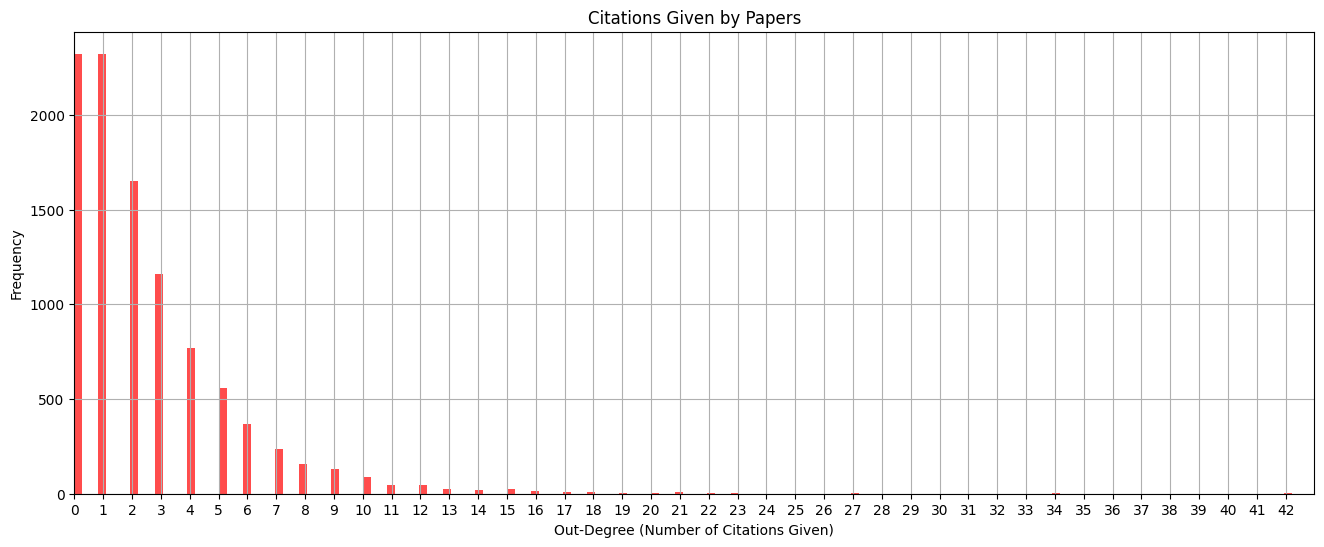

In [11]:
###############VISUALISATION##############################
#here I create my menu and visualisation system

#create the two buttons of the home page
btn_visualization_system = widgets.Button(description="Visualization System", button_style='info')
btn_exit = widgets.Button(description="Exit", button_style='danger')

#define what the exit button does 
def exit_clicked(b):
    clear_output(wait=True)
    print("System exited")
    # You can add additional cleanup or exit code here

#define what the visualisation system button does
def display_buttons(b=None):
    clear_output(wait=True)
    display(btn_visualization_system, btn_exit)

#define the second page
def visualization_system_clicked(b):
    clear_output(wait=True)
    print("Select the graph you want to investigate:")
    
    #create the other buttons to show in the second page
    btn_collaboration_graph = widgets.Button(description="Collaboration Graph", button_style='primary')
    btn_citation_graph = widgets.Button(description="Citation Graph", button_style='success')
    btn_return = widgets.Button(description="Return", button_style='warning')
    
    #define first button graph
    def collaboration_graph_clicked(b):
        clear_output(wait=True)
        display_graph_options(N, "Collaboration Graph")

    #define second button graph
    def citation_graph_clicked(b):
        clear_output(wait=True)
        display_graph_options(G, "Citation Graph")

    #define the return button 
    def return_clicked(b):
        display_buttons()  #it goes back to the beginning but it will not exit the system

    #when the button is clicked, do its functions
    btn_collaboration_graph.on_click(collaboration_graph_clicked)
    btn_citation_graph.on_click(citation_graph_clicked)
    btn_return.on_click(return_clicked)

    #display buttons of the second page
    display(btn_collaboration_graph, btn_citation_graph, btn_return)

#once the user choose a graph, do this
def display_graph_options(graph, graph_name):
    clear_output(wait=True)
    #print name and instructions on what to do
    print(f"Graph Selected: {graph_name}. Select the feature you want to investigate:")
    
    #create buttons of the third page (graph-specific)
    btn_table = widgets.Button(description="General Information", button_style='primary')
    btn_hubs = widgets.Button(description="Graph's Hubs", button_style='primary')
    btn_citation_received = widgets.Button(description="Citations Received Plot", button_style='primary')
    btn_citation_gived = widgets.Button(description="Citations Gived Plot", button_style='primary')
    btn_collaborations = widgets.Button(description="Collaborations Plot", button_style='primary')
    btn_return = widgets.Button(description="Return", button_style='warning')

    #create the button to display the general info 
    def table_clicked(b):
        clear_output(wait=True)
        print(graph_features(graph, graph_name))

    #display hubs
    def hubs_clicked(b):
        clear_output(wait=True)
        hubs = nx.degree(graph)
        hubs = [node for node, degree in hubs if degree > 0]  
        print(f"Graph Hubs for '{graph_name}':\n{hubs}")

    #plot of the citation received
    def citation_received_clicked(b):
        #it will be visible only for the citation graph, so to remind the user it is a graph-specific feature, I remind it here
        print("\033[91;1mWARNING: THIS FEATURE IS AVAILABLE ONLY FOR THE CITATION GRAPH!!!\033[0m")
        #exploit the structure of the graph
        in_degrees = dict(G.in_degree())
        in_degree_values = list(in_degrees.values())

        #plot
        plt.figure(figsize=(16, 6))
        plt.hist(in_degree_values, bins=100, color='red', alpha=0.7)
        plt.title('Citations Received by Papers')
        plt.xlabel('In-Degree (Number of Citations Received)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.xlim(0,70)
        plt.show()

    #plot the citation gived
    def citation_gived_clicked(b):
        #it will be visible only for the citation graph, so to remind the user it is a graph-specific feature, I remind it here
        print("\033[91;1mWARNING: THIS FEATURE IS AVAILABLE ONLY FOR THE CITATION GRAPH!!!\033[0m")
        #exploit the structure of the greph 
        out_degrees = dict(G.out_degree())
        out_degree_values = list(out_degrees.values())

        #plot
        plt.figure(figsize=(16, 6))
        plt.hist(out_degree_values, bins="auto", color='r', alpha=0.7)
        plt.title('Citations Given by Papers')
        plt.xlabel('Out-Degree (Number of Citations Given)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.xlim(0,43)
        plt.xticks(np.arange(0, 43))
        plt.show()

    #plot collaborations
    def collaborations_clicked(b):
        #it will be visible only for the collaboration graph, so to remind the user it is a graph-specific feature, I remind it here
        print("\033[91;1mWARNING: THIS FEATURE IS AVAILABLE ONLY FOR THE COLLABORATION GRAPH!!!\033[0m")
        degrees = dict(N.degree())
        #I retrieve only the top 50 as the graph is pretty big
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:50]

        plt.figure(figsize=(16, 6))
        plt.hist([degrees[node] for node in top_nodes], bins=100, color='red', alpha=0.7)
        plt.title('N collaborations for Top 50 Authors')
        plt.xlabel('N')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.xticks(np.arange(235, 261))  
        plt.xlim(240,260)
        plt.show()


    def return_clicked(b):
        display_buttons()  #return button. works as before 

    #here we do the following:
    #if the button clicked is Citation graph, then hide the button that does not concern that graph  
    if graph_name == "Citation Graph":
        btn_collaborations.layout.visibility = 'hidden'
    #here we do the same
    if graph_name == "Collaboration Graph":
        btn_citation_gived.layout.visibility = 'hidden'
        btn_citation_received.layout.visibility = 'hidden'
    
    #if clicked, do this
    btn_table.on_click(table_clicked)
    btn_hubs.on_click(hubs_clicked)
    btn_citation_received.on_click(citation_received_clicked)
    btn_citation_gived.on_click(citation_gived_clicked)
    btn_collaborations.on_click(collaborations_clicked)
    btn_return.on_click(return_clicked)

    #display button of the third page 
    display(btn_table, btn_hubs, btn_citation_received, btn_citation_gived, btn_collaborations, btn_return)

#if clicked, do this. Those two are for the two buttons of the homepage
btn_exit.on_click(exit_clicked)
btn_visualization_system.on_click(visualization_system_clicked)

#show the buttons of the homepage
display_buttons()

---

<code style="background:red;color:black">**little comment:**</code> <br>
We have a lot of results. <br>
We can understand that we are dealing with a sparse and a dense graph with several information that can be investigated into the general info table (such as n of nodes, edges, hubs etc..). <br>
Then we can investigate the number of citations gived and received and the colaborators of authors thanks to plots. <br>
In this specific plot, we investigate the citation gived by paper (references). <br>
We can clearly observe that the more citation a paper give, the less the number of the papers are. So, we find a lot of papers with just one or two citations (also 0) and very few with several citations. <br>
This is problematic from a "substance" point-of-view. In a scientific field a paper with 0, 1 or 2 references is not very consistent and should be avoided/not-trusted. <br>
For Instance, in the biological field, a paper with such few references will not be taken seriously by peers and there is little chance for it to be published in important journals (such as "Current Biology"). On one hand, this is due to the fact that infromation must be cited and it is very rare (or impossible) that all data/knowledge contained in a paper is completely from the author(s). On the other, few references may indicate poor organisation and seriousness from the author(s) or fabrication/manipulation of data and/or results.  <br>
To conclude, the papers in this dataset may not be very consistent due to their lack of references.

---

### Visualization 2 - Visualize the node's contribution

<code style="background:orange;color:black">**Introduction:**</code> <br>
As before, we create an interactive menu for the user. <br>
It is very similar to the previous one but this time after choosing the graph, you are asked to input a number (our node of interest) <br>
Then the system will return the result from the function previously created and plot it in a nice table.

In [ ]:
#create home buttons 
btn_os_selection = widgets.Button(description="Visualization Systems", button_style='primary')
btn_return_main = widgets.Button(description="Exit", button_style='danger')

#if the system is entered, show these buttons
def os_selection_clicked(b):
    clear_output(wait=True)
    display(btn_citation_graph, btn_collaboration_graph, btn_return_sub, btn_return_main)

#exit
def return_main_clicked(b):
    clear_output(wait=True)
    print("System exited")

#if clicked, do this
btn_os_selection.on_click(os_selection_clicked)
btn_return_main.on_click(return_main_clicked)

#show home buttons
display(btn_os_selection, btn_return_main)


#create buttons of the second page
btn_citation_graph = widgets.Button(description="Citation Graph", button_style='primary')
btn_collaboration_graph = widgets.Button(description="Collaboration Graph", button_style='primary')
btn_return_sub = widgets.Button(description="Return", button_style='warning')

#store the graph selected (citation or collaboration)
selected_graph_type = None

#here we retrieve the description of the button clicked.
#this will be needed in few steps because we need to understand which graphs we are using
#(so the graph of the function must be different)
def graph_selection_clicked_sub(b):
    clear_output(wait=True)
    global selected_graph_type
    selected_graph_type = b.description.lower()
    display(input_node, btn_return_result)

#when selected, return the input
def return_sub_clicked(b):
    clear_output(wait=True)
    display(btn_os_selection, btn_return_main)

#when selected, do this
btn_citation_graph.on_click(graph_selection_clicked_sub)
btn_collaboration_graph.on_click(graph_selection_clicked_sub)
btn_return_sub.on_click(return_sub_clicked)

#create buttons for the input part
input_node = widgets.IntText(value=1, description='Node Number:', style={'description_width': 'initial'})
btn_return_result = widgets.Button(description="Submit", button_style='warning')

#when the result is inputed, first, print a message to ask some patient,
#then, check which graph has been selected
def return_result_clicked(b):
    clear_output(wait=True)
    node = input_node.value
    print("Retrieving results; this could take some minutes, please wait...")
    
    #if citation graph has been selected
    if selected_graph_type == "citation graph":
        #perfrom the function with the correct graph 
        result = centrality(G, node, "Citation Graph")
    #if collaboration graph has been selected
    elif selected_graph_type == "collaboration graph":
        #perfrom the function with the correct graph 
        result = centrality(N, node, "Collaboration Graph")

    #show results 
    print(f"Result for node {node} in the {selected_graph_type}:")
    print(result)

btn_return_result.on_click(return_result_clicked)


Retrieving results; this could take some minutes, please wait...
Result for node 2893933380 in the citation graph:
Graph Features Report for 'Citation Graph':
╒══════════════════════╤═════════════╕
│ Feature              │       Value │
╞══════════════════════╪═════════════╡
│ Betweenness          │ 9.35727e-06 │
├──────────────────────┼─────────────┤
│ Pagerank             │ 7.83614e-05 │
├──────────────────────┼─────────────┤
│ Closeness Centrality │ 0.00040004  │
├──────────────────────┼─────────────┤
│ Degree Centrality    │ 0.0010001   │
╘══════════════════════╧═════════════╛


---

<code style="background:red;color:black">**Little comment:**</code> <br>
These values provide insights into the importance and position of the node within the graph, highlighting its role in connecting other nodes, its influence, its proximity to other nodes, and its overall connectivity. <br>
Since all values values are very low, this suggests that the node may not be a critical bridge between different parts of the network. <br>



---

### Visualization 3 - Visualize the shortest-ordered route

<code style="background:orange;color:black">**Introduction:**</code> <br>
This time the menu is a little bit more complex: <br>
Since this works only for collaboration graph, you will not be required to select the graph as it will be automatic. <br>
However, the user will have to input lots of variables: the input node, the destination node, the top authors and the sequence. <br>
After that, the system will return the shortest path and the papers (in order) and will plot the graph that identify the nodes and edges that appear in the shortest walk.

Retrieving results; this could take some minutes, please wait...
Shortest path for 2133227394 and 332422508:
Cost Table:
+------+
| Cost |
+------+
|  22  |
+------+

Path Table:
+-------------------------+------------+------------+
|           Edge          | From Node  |  To Node   |
+-------------------------+------------+------------+
| (2133227394, 173839695) | 2133227394 | 173839695  |
| (173839695, 2111642879) | 173839695  | 2111642879 |
| (2111642879, 332422508) | 2111642879 | 332422508  |
+-------------------------+------------+------------+


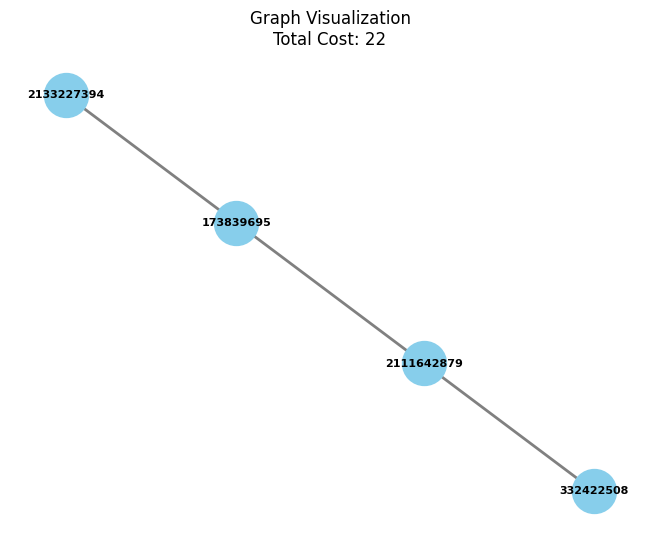

In [12]:
#function that will output the result in a very pretty way :)
def plot_shortest_path(result):
    # Extract data from the result
    total_cost, shortest_path = result

    # Create a PrettyTable for the cost
    cost_table = PrettyTable(["Cost"])
    cost_table.add_row([total_cost])

    # Create a PrettyTable for the nodes and path
    path_table = PrettyTable(["Edge", "From Node", "To Node"])
    for edge in shortest_path:
        path_table.add_row([f"({edge[0]}, {edge[1]})", edge[0], edge[1]])

    # Print the tables
    print("Cost Table:")
    print(cost_table)
    
    print("\nPath Table:")
    print(path_table)


#function for the visualisation of the graph
def visualize_result(result, G_data=collaboration_data):
    G = graph(G_data['nodes'], G_data['edges'], {'weigths': G_data['weigths']}, G_data['dir'])
    cost, edges = result
    #create it
    G_result = nx.Graph()
    #add nodes and edges
    for edge in edges:
        G_result.add_edge(edge[0], edge[1])

    #plot
    pos = nx.spring_layout(G_result)
    nx.draw(G_result, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=1000, font_size=8, edge_color='gray', width=2)
    plt.title(f"Graph Visualization\nTotal Cost: {cost}")
    plt.show()


######################VISUALISATION##############################

# Create home buttons
btn_os_selection = widgets.Button(description="Visualization Systems", button_style='primary')
btn_return_main = widgets.Button(description="Exit", button_style='danger')

# If the system is entered, show these buttons
def os_selection_clicked(b):
    clear_output(wait=True)
    # Print name and instructions on what to do
    print("Please input the two nodes you want to calculate the shortest path:")
    print("Please input the sequence authors with comma separated values:")
    print("Please input number of top authors whose data should be considered (integer):")
    
    # Display input buttons and sequence input on the same line
    display(widgets.HBox([input_node1, input_node2, input_sequence, input_N]))
    
    # Display buttons below the input widgets
    display(widgets.HBox([btn_submit, btn_return_sub, btn_return_main]))

# Create buttons for the input part
input_node1 = widgets.IntText(value=1, description='Starting Node:', style={'description_width': 'initial'})
input_node2 = widgets.IntText(value=1, description='Destination Node:', style={'description_width': 'initial'})
input_sequence = widgets.Text(value='', description='Sequence:', style={'description_width': 'initial'})  # Updated input widget
input_N = widgets.IntText(value=1, description='N authors:', style={'description_width': 'initial'})
btn_submit = widgets.Button(description="Submit", button_style='success')

# Exit
def return_main_clicked(b):
    clear_output(wait=True)
    print("System exited")

# If clicked, do this
btn_os_selection.on_click(os_selection_clicked)
btn_return_main.on_click(return_main_clicked)

# Show home buttons
display(btn_os_selection, btn_return_main)

# Create buttons of the second page
btn_return_sub = widgets.Button(description="Return", button_style='warning')

# When selected, return to the input
def return_sub_clicked(b):
    clear_output(wait=True)
    display(btn_os_selection, btn_return_main)

btn_return_sub.on_click(return_sub_clicked)

# When the result is inputted, first, print a message to ask some patience,
# then, check which graph has been selected
def return_result_clicked(b):
    clear_output(wait=True)
    node1 = input_node1.value
    node2 = input_node2.value
    N = input_N.value
    seq_input = [int(x.strip()) for x in input_sequence.value.split(',')]
    print("Retrieving results; this could take some minutes, please wait...")

    # Results
    result = shortestpath_sequence(seq_input, node1, node2, N)
    print(f"Shortest path for {node1} and {node2}:")
    plot_shortest_path(result)

    #plot
    visualize_result(result)

btn_submit.on_click(return_result_clicked)

---

<code style="background:red;color:black">**Little comment:**</code> <br>
The cost of this path (22) is crucial in understanding the most efficient route or connection between these two nodes in the context of the graph, where the edges may represent various relationships or distances. <br>
In the plot we can see how the nodes are connected, showing the path found.

---